# Devoir 4

## Imports


In [0]:
from keras.datasets import cifar10
from sklearn.utils import shuffle
import cv2

import numpy as np
from scipy import ndimage
import matplotlib.pylab as pl
from google.colab import files, drive
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from sklearn.metrics import mean_squared_error
import math

#from livelossplot import PlotLossesKeras


ModuleNotFoundError: ignored

In [0]:
(xtrain1, ytrain1), (xtest, ytest) = cifar10.load_data()

print(xtrain1.shape, ytrain1.shape)
print(xtest.shape, ytest.shape)

170500096/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [0]:
train_rate = 0.8
index_train = np.random.choice(xtrain1.shape[0],int(xtrain1.shape[0]*train_rate),replace=False)
index_val  = list(set(range(xtrain1.shape[0])) - set(index_train))
                            
xtrain1, ytrain1 = shuffle(xtrain1, ytrain1)
xtrain, ytrain = xtrain1[index_train], ytrain1[index_train]
xval, yval = xtrain1[index_val], ytrain1[index_val]
print(xtrain.shape, ytrain.shape)
print(xval.shape, yval.shape)

(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)


In [0]:
pl.figure(1, figsize=(10, 50))
for i in range(500):
    pl.subplot(50, 10, i+1)
    pl.imshow(xtrain[i])
    pl.axis('off')
    pl.title(str(i))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
pl.figure(1, figsize=(10, 50))
for i in range(500):
    pl.subplot(50, 10, i+1)
    pl.imshow(xval[i])
    pl.axis('off')
    pl.title(str(i))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
pl.figure(1, figsize=(10, 50))
for i in range(500):
    pl.subplot(50, 10, i+1)
    pl.imshow(xtest[i])
    pl.axis('off')
    pl.title(str(i))

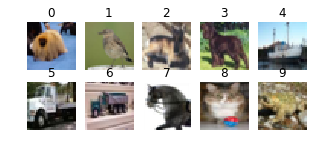

In [0]:
pl.figure(1, figsize=(5, 2))
for i in range(10):
    pl.subplot(2, 5, i+1)
    pl.imshow(xtrain[i])
    pl.axis('off')
    pl.title(str(i))

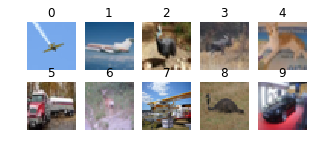

In [0]:
pl.figure(1, figsize=(5, 2))
for i in range(10):
    pl.subplot(2, 5, i+1)
    pl.imshow(xval[i])
    pl.axis('off')
    pl.title(str(i))

flattened feature vector size: 300


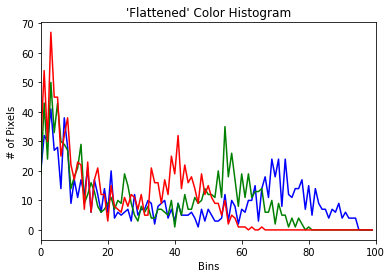

In [0]:
chans = cv2.split(xtrain[0])
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")

features = []
 
bin_size = 100
  
# loop over the image channels
for (chan, color) in zip(chans, colors):
	# create a histogram for the current channel and
	# concatenate the resulting histograms for each
	# channel
	hist = cv2.calcHist([chan], [0], None, [bin_size], [0, 256]) #[32] [256]
	features.extend(hist)
 
	# plot the histogram
	plt.plot(hist, color = color)
	plt.xlim([0, bin_size])
 
# here we are simply showing the dimensionality of the
# flattened color histogram 256 bins for each channel
# x 3 channels = 768 total values -- in practice, we would
# normally not use 256 bins for each channel, a choice
# between 32-96 bins are normally used, but this tends
# to be application dependent
print("flattened feature vector size: %d" % (np.array(features).flatten().shape))

(32, 32)
(32, 32)
(32, 32)
2D histogram shape: (32, 32), with 1024 values


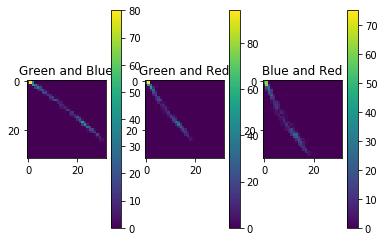

In [0]:
# let's move on to 2D histograms -- I am reducing the
# number of bins in the histogram from 256 to 32 so we
# can better visualize the results
fig = plt.figure()
 
# plot a 2D color histogram for green and blue
ax = fig.add_subplot(131)
hist = cv2.calcHist([chans[1], chans[0]], [0, 1], None,
	[32, 32], [0, 256, 0, 256])
print(hist.shape)
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("Green and Blue")
plt.colorbar(p)
 
# plot a 2D color histogram for green and red
ax = fig.add_subplot(132)
hist = cv2.calcHist([chans[1], chans[2]], [0, 1], None,
	[32, 32], [0, 256, 0, 256])
print(hist.shape)
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("Green and Red")
plt.colorbar(p)
 
# plot a 2D color histogram for blue and red
ax = fig.add_subplot(133)
hist = cv2.calcHist([chans[0], chans[2]], [0, 1], None,
	[32, 32], [0, 256, 0, 256])
print(hist.shape)
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("Blue and Red")
plt.colorbar(p)
 
# finally, let's examine the dimensionality of one of
# the 2D histograms
print("2D histogram shape: %s, with %d values" % (hist.shape, hist.flatten().shape[0]))

In [0]:
# our 2D histogram could only take into account 2 out
# of the 3 channels in the image so now let's build a
# 3D color histogram (utilizing all channels) with 8 bins
# in each direction -- we can't plot the 3D histogram, but
# the theory is exactly like that of a 2D histogram, so
# we'll just show the shape of the histogram

bin_number = 8

hist = cv2.calcHist([xtrain[0]], [0, 1, 2],
	None, [bin_number, bin_number, bin_number], [0, 256, 0, 256, 0, 256])
print("3D histogram shape: %s, with %d values" % (hist.shape, hist.flatten().shape[0]))

print(xtrain[0].shape)
print("From 3072 to 512 : compression factor of 6")

3D histogram shape: (8, 8, 8), with 512 values
(32, 32, 3)
From 3072 to 512 : compression factor of 6


In [0]:
xtrain_rgb_features = np.zeros((len(xtrain),bin_number*bin_number*bin_number))

for i in range(len(xtrain)):
  hist = cv2.calcHist([xtrain[i]], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
  xtrain_rgb_features[i] = hist.flatten()

print(len(xtrain))

40000


In [0]:
def chi2_distance(histA, histB, eps = 1e-10):
  # compute the chi-squared distance
  d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
    for (a, b) in zip(histA, histB)])

  # return the chi-squared distance
  return d

## testing the rgb features

Text(0.5, 1.0, 'query image')

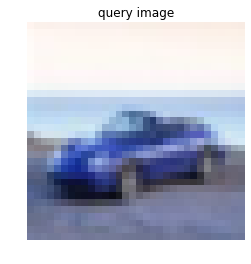

In [0]:
img_id = 12 #1 2 4 5 12

pl.figure()
pl.imshow(xval[img_id])
pl.axis('off')
pl.title("query image")

In [0]:
    
hist = cv2.calcHist([xval[img_id]], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
features = hist.flatten()

dist = np.zeros(len(xtrain_rgb_features))
dist_chi = np.zeros(len(xtrain_rgb_features))

for i in range(len(xtrain_rgb_features)):
  dist[i] = np.linalg.norm(xtrain_rgb_features[i] - features) 
  dist_chi[i] = chi2_distance(xtrain_rgb_features[i], features)
  
index_sort = np.argsort(dist) 
dist_sort = dist[index_sort]

#print(dist[0:10])
#print(dist_sort[0:10])
#print(index_sort)

index_sort_chi = np.argsort(dist_chi) 
dist_sort_chi = dist[index_sort_chi]

#print(dist_chi[0:10])
#print(dist_sort_chi[0:10])
#print(index_sort_chi)


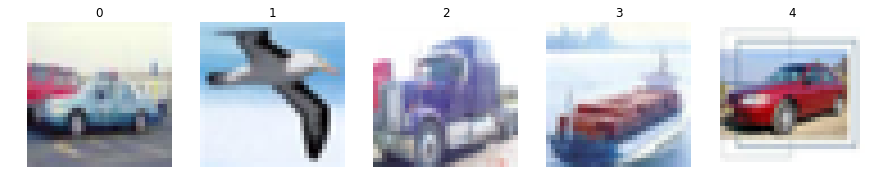

In [0]:
images = xtrain[index_sort]
images_chi = xtrain[index_sort_chi]

ratio = 3

pl.figure(1, figsize=(5*ratio, 1*ratio))
for i in range(5):
    pl.subplot(1, 5, i+1)
    pl.imshow(images[i])
    pl.axis('off')
    pl.title(str(i))
    

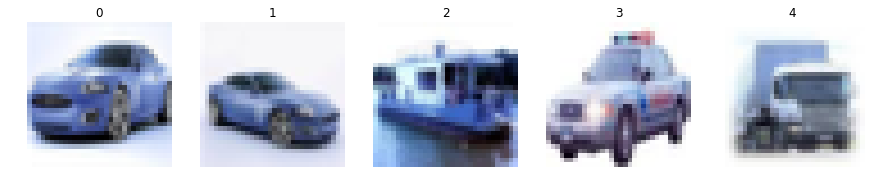

In [0]:
ratio = 3

pl.figure(1, figsize=(5*ratio, 1*ratio))
for i in range(5):
    pl.subplot(1, 5, i+1)
    pl.imshow(images_chi[i])
    pl.axis('off')
    pl.title(str(i))

## CBIR geometric features

HOG based

In [0]:
from skimage import exposure
from skimage import feature

Text(0.5, 1.0, 'query image')

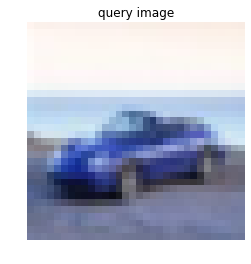

In [0]:
img_id = 12 #1 2 4 5 12

pl.figure()
pl.imshow(xval[img_id])
pl.axis('off')
pl.title("query image")

In [0]:
image = xtrain[img_id]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cell_size = 4 #10

# extract Histogram of Oriented Gradients from the logo
H = feature.hog(gray, orientations=9, pixels_per_cell=(cell_size, cell_size),cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

print(image.shape)
print(H.shape)
print("compression factor : 21.33")

(32, 32, 3)
(1764,)
compression factor : 21.33


In [0]:
xtrain_hog_features = np.zeros((len(xtrain),len(H)))

for i in range(len(xtrain)):
  gray = cv2.cvtColor(xtrain[i], cv2.COLOR_BGR2GRAY)
  hist = feature.hog(gray, orientations=9, pixels_per_cell=(cell_size, cell_size),cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
  xtrain_hog_features[i] = hist

print(len(xtrain))

40000


In [0]:
#hist = cv2.calcHist([xval[img_id]], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
hist = feature.hog(xval[img_id], orientations=9, pixels_per_cell=(cell_size, cell_size),cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
features = hist

dist = np.zeros(len(xtrain_hog_features))
dist_chi = np.zeros(len(xtrain_hog_features))

for i in range(len(xtrain_hog_features)):
  dist[i] = np.linalg.norm(xtrain_hog_features[i] - features) 
  dist_chi[i] = chi2_distance(xtrain_hog_features[i], features)
  
index_sort = np.argsort(dist) 
dist_sort = dist[index_sort]

print(dist[0:10])
print(dist_sort[0:10])
print(index_sort)

index_sort_chi = np.argsort(dist_chi) 
dist_sort_chi = dist[index_sort_chi]

print(dist_chi[0:10])
print(dist_sort_chi[0:10])
print(index_sort_chi)

[3.02188644 3.2592397  2.94097293 2.84010583 2.95314898 2.85647552
 2.62082521 3.33656067 2.88857343 2.76125153]
[1.95374793 1.95969935 1.98542499 1.98848389 2.00363169 2.00837077
 2.02205272 2.02734851 2.03688293 2.05954368]
[21760 30184 28150 ... 38554  7517 27345]
[29.22278922 31.10301648 29.56172898 28.15431791 25.31157763 28.41164204
 23.36670392 31.05862678 27.7194825  26.44143025]
[2.182009   1.98848389 2.00363169 2.13280626 2.12747542 2.11409247
 2.23184277 2.02734851 2.03688293 1.95969935]
[35413 29417  6687 ... 37554 15179 10254]


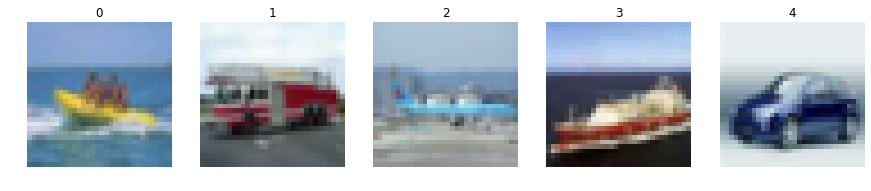

In [0]:
images = xtrain[index_sort]
images_chi = xtrain[index_sort_chi]

ratio = 3

pl.figure(1, figsize=(5*ratio, 1*ratio))
for i in range(5):
    pl.subplot(1, 5, i+1)
    pl.imshow(images[i])
    pl.axis('off')
    pl.title(str(i))

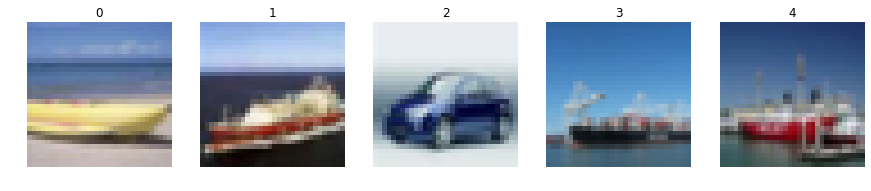

In [0]:
ratio = 3

pl.figure(1, figsize=(5*ratio, 1*ratio))
for i in range(5):
    pl.subplot(1, 5, i+1)
    pl.imshow(images_chi[i])
    pl.axis('off')
    pl.title(str(i))

## SIFT for CBIR

In [0]:
sift = cv.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)

## Convolutional Autoencoder

Features extraction using CAE

In [0]:
# normalize data
xtrain_n = xtrain.astype('float32')
xval_n = xval.astype('float32')
xtest_n = xtest.astype('float32')
xtrain_n /= 255
xval_n /= 255
xtest_n /= 255

In [0]:
# Convolutional AE: use images in 3D, not flattened
# AE1
# size code --> /4

input_img = Input(shape=(len(xtrain[0]),len(xtrain[0,0]),len(xtrain[0,0,0]))) 

# 196608 dimensions if 256
# 49152 if 128

net = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
#net = Dropout(0.25)(net)
net = MaxPooling2D((2, 2), padding='same')(net)
net = Conv2D(8, (3, 3), activation='relu', padding='same')(net)
encoded = MaxPooling2D((2, 2), padding='same')(net)

# "code" layer: at this point the representation is 
  # (32, 32, 8) --> 8192 dimensions 

net = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
net = UpSampling2D((2, 2))(net)
net = Conv2D(16, (3, 3), activation='relu', padding='same')(net)
net = UpSampling2D((2, 2))(net)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(net)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

#plot_model(autoencoder, to_file=path+'autoencoder.png', show_shapes=True)
#SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 16, 8)         0         
__________

In [0]:
history = autoencoder.fit(xtrain_n, xtrain_n,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(xval_n, xval_n),
                         verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
 - 7s - loss: 0.0119 - val_loss: 0.0072
Epoch 2/50
 - 6s - loss: 0.0066 - val_loss: 0.0061
Epoch 3/50
 - 6s - loss: 0.0059 - val_loss: 0.0057
Epoch 4/50
 - 6s - loss: 0.0055 - val_loss: 0.0053
Epoch 5/50
 - 6s - loss: 0.0052 - val_loss: 0.0051
Epoch 6/50
 - 6s - loss: 0.0050 - val_loss: 0.0049
Epoch 7/50
 - 6s - loss: 0.0049 - val_loss: 0.0048
Epoch 8/50
 - 6s - loss: 0.0048 - val_loss: 0.0047
Epoch 9/50
 - 6s - loss: 0.0047 - val_loss: 0.0046
Epoch 10/50
 - 6s - loss: 0.0046 - val_loss: 0.0048
Epoch 11/50
 - 6s - loss: 0.0046 - val_loss: 0.0045
Epoch 12/50
 - 6s - loss: 0.0045 - val_loss: 0.0045
Epoch 13/50
 - 6s - loss: 0.0045 - val_loss: 0.0044
Epoch 14/50
 - 6s - loss: 0.0044 - val_loss: 0.0044
Epoch 15/50
 - 6s - loss: 0.0044 - val_loss: 0.0044
Epoch 16/50
 - 6s - loss: 0.0044 - val_loss: 0.0043
Epoch 17/50
 - 6s - loss: 0.0044 - val_loss: 0.0044
Epoch 18/50
 - 6s - loss: 0.0043 - val_loss: 0.0043
Epoch 19/50
 - 6s - los

In [0]:
#Model bis

input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [0]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
history = model.fit(x_train_n, x_train_n,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val_n, x_val_n),
                    shuffle=True)

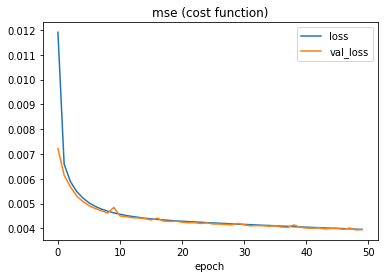

In [0]:
for key in ['loss', 'val_loss']:
    plt.plot(history.history[key],label=key)
    plt.title("mse (cost function)")
    plt.xlabel('epoch')
plt.legend()
plt.show()

In [0]:
for key in ['acc', 'val_acc']:
    plt.plot(history.history[key],label=key)
    plt.title("Accuracy")
    plt.xlabel('epoch')
plt.legend()
plt.show()

KeyError: ignored

Text(0.5, 1.0, 'Cat 2')

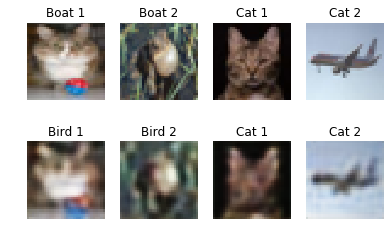

In [0]:
decoded_imgs = autoencoder.predict(xtrain_n)
decoded_rs = decoded_imgs.reshape(len(xtrain), len(xtrain[0])*len(xtrain[0,0])*len(xtrain[0,0,0]))

#print(mean_squared_error(xrs,decoded_rs))

#decoded_imgs = autoencoder.predict(xval)
#decoded_vrs = decoded_imgs.reshape(len(xval), len(xval[0])*len(xval[0,0])*len(xval[0,0,0]))

#print(mean_squared_error(xvrs,decoded_rs))
# --> same error on validation set (from previous plot, we see that the two errors converge)


# plot 2 images of each class
pl.figure(1, figsize=(6.4, 4))

pl.subplot(2, 4, 1)
pl.imshow(xtrain[8])
pl.axis('off')
pl.title('Boat 1')

pl.subplot(2, 4, 2)
pl.imshow(xtrain[14])
pl.axis('off')
pl.title('Boat 2')

pl.subplot(2, 4, 3)
pl.imshow(xtrain[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(2, 4, 4)
pl.imshow(xtrain[386])
pl.axis('off')
pl.title('Cat 2')

pl.subplot(2, 4, 5)
pl.imshow(decoded_imgs[8])
pl.axis('off')
pl.title('Bird 1')

pl.subplot(2, 4, 6)
pl.imshow(decoded_imgs[14])
pl.axis('off')
pl.title('Bird 2')

pl.subplot(2, 4, 7)
pl.imshow(decoded_imgs[323])
pl.axis('off')
pl.title('Cat 1')

pl.subplot(2, 4, 8)
pl.imshow(decoded_imgs[386])
pl.axis('off')
pl.title('Cat 2')

8


Text(0.5, 1.0, 'Cat 2')

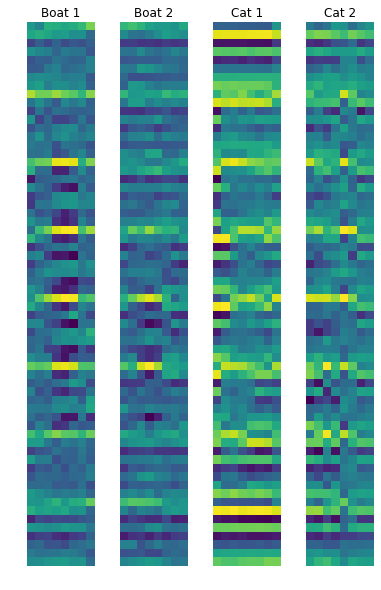

In [0]:
# Show encoded representations
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(xtrain_n)
pl.figure(1, figsize=(6.4, 10))

s = int(len(xtrain[0])/4)
print(s)

pl.subplot(1, 4, 1)
pl.imshow(encoded_imgs[8].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Boat 1')

pl.subplot(1, 4, 2)
pl.imshow(encoded_imgs[14].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Boat 2')

pl.subplot(1, 4, 3)
pl.imshow(encoded_imgs[323].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cat 1')

pl.subplot(1, 4, 4)
pl.imshow(encoded_imgs[286].reshape(s, s * 8).T)
pl.axis('off')
pl.title('Cat 2')

### testing the CAE

Text(0.5, 1.0, 'query image')

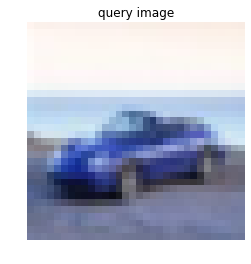

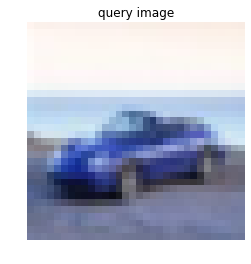

In [0]:
img_id = 12 #1 2 4 5 12

pl.figure()
pl.imshow(xval[img_id])
pl.axis('off')
pl.title("query image")

pl.figure()
pl.imshow(xval_n[img_id])
pl.axis('off')
pl.title("query image")

In [0]:
xtrain_cae_features = np.zeros((len(xtrain),8*8*8))

xtrain_cae_features = encoder.predict(xtrain_n)

features_all = encoder.predict(xval_n)

print(xtrain.shape)
print(xtrain_cae_features.shape)

(40000, 32, 32, 3)
(40000, 8, 8, 8)


In [0]:
features = features_all[img_id]

dist = np.zeros(len(xtrain_cae_features))
dist_chi = np.zeros(len(xtrain_cae_features))

for i in range(len(xtrain_cae_features)):
  dist[i] = np.linalg.norm(xtrain_cae_features[i] - features) 
  dist_chi[i] = chi2_distance(xtrain_cae_features[i], features)
  
index_sort = np.argsort(dist) 
dist_sort = dist[index_sort]

print(dist[0:10])
print(dist_sort[0:10])
print(index_sort)

index_sort_chi = np.argsort(dist_chi) 
dist_sort_chi = dist[index_sort_chi]

print(dist_chi[0:10])
print(dist_sort_chi[0:10])
print(index_sort_chi)

[9.46410751 8.0847702  7.44734383 9.91682148 5.37640238 9.20636463
 7.09398556 9.55916595 9.11383533 7.78513193]
[3.14367318 3.20520878 3.2335639  3.24439287 3.27777052 3.28727746
 3.31212902 3.3314507  3.38466215 3.38702464]
[18728 39195 11911 ... 38376 18096 17973]
[38.29993439 31.87647247 27.24075508 42.6368866  13.29213333 37.79353333
 24.62239075 41.51288986 37.78313446 29.99733353]
[3.14367318 3.2335639  3.31212902 3.3314507  3.52879453 3.4388988
 3.27777052 3.38702464 3.50592017 3.20520878]
[18728 11911 19749 ...  4144 17973  6752]


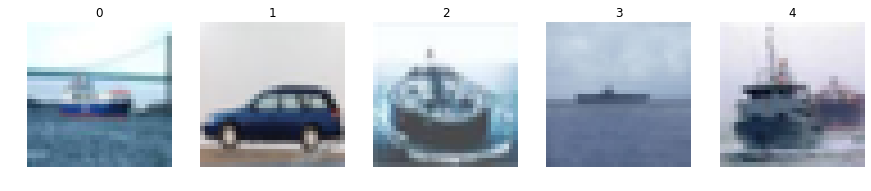

In [0]:
images = xtrain[index_sort]
images_chi = xtrain[index_sort_chi]

ratio = 3

pl.figure(1, figsize=(5*ratio, 1*ratio))
for i in range(5):
    pl.subplot(1, 5, i+1)
    pl.imshow(images[i])
    pl.axis('off')
    pl.title(str(i))

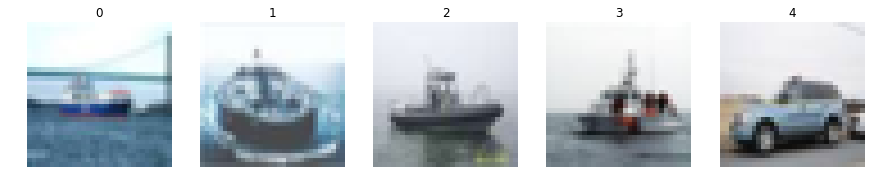

In [0]:
ratio = 3

pl.figure(1, figsize=(5*ratio, 1*ratio))
for i in range(5):
    pl.subplot(1, 5, i+1)
    pl.imshow(images_chi[i])
    pl.axis('off')
    pl.title(str(i))